## Лабораторная работа №3.

Дедлайн: 21 мая 23:59

### Часть 1. Overfit it (1.5 points)

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.94 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import string
from IPython.display import clear_output
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

sns.set()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train = FashionMNIST(root='./data', download=True, train=True, transform=transforms.ToTensor())
test = FashionMNIST(root='./data', download=True, train=False, transform=transforms.ToTensor())

In [0]:
def train_epoch(model, criterion, optimizer, batch_size):
    losses = []
    model.train()
    for data, label in torch.utils.data.DataLoader(train, batch_size=batch_size):
        data, label = data.to(device), label.to(device)
        pred = model(data)
        loss = criterion(pred, label)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return np.mean(losses)
        
        
def model_accuracy(model, dataset, criterion, batch_size):
    model.eval()
    correct, total = 0, 0
    losses = []
    for data, label in torch.utils.data.DataLoader(dataset, batch_size=batch_size):
        data, label = data.to(device), label.to(device)
        pred = model(data)
        loss = criterion(pred, label)
        _, pred_label = torch.max(pred.data, 1)
        correct += (pred_label == label).sum().item()
        total += label.shape[0]
        
    return correct / total

In [0]:
# https://github.com/Xfan1025/Fashion-MNIST/blob/master/fashion-mnist.ipynb
class Xfan1025(nn.Module):
    def __init__(self):
        super(Xfan1025, self).__init__()
        self.norm1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.pool1 = nn.MaxPool2d(2, 2, 0)
        self.conv2 = nn.Conv2d(64, 512, 5)
        self.pool2 = nn.MaxPool2d(2, 2, 0)
        self.input_size = 512 * 4 * 4
        self.fc1 = nn.Linear(self.input_size, 128)
        self.drop1 = nn.Dropout(0.35)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.35)
        self.fc3 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        x = self.norm1(x)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, self.input_size)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.softmax(self.fc3(x), dim=1)
        return x

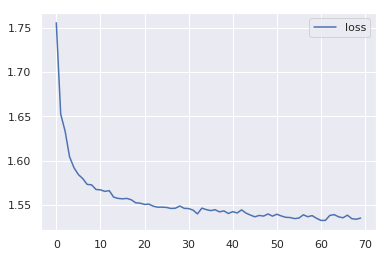

Test accuracy is 0.90360


In [5]:
model = Xfan1025().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

batch_size = 256
epochs = 70

history = []

for i in range(epochs):
    loss = train_epoch(model, criterion, optimizer, batch_size)
    history.append(loss)
    if (i+1)%5==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

print(f'Test accuracy is {model_accuracy(model, test, criterion, batch_size):.5f}')

In [0]:
# https://github.com/cmasch/zalando-fashion-mnist/blob/master/Simple_Convolutional_Neural_Network_Fashion-MNIST.ipynb
class Cmasch(nn.Module):
    def __init__(self):
        super(Cmasch, self).__init__()
        self.norm1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 64, 4, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2, 0)
        self.drop1 = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(64, 64, 4)
        self.pool2 = nn.MaxPool2d(2, 2, 0)
        self.drop2 = nn.Dropout(0.3)
        self.input_size = 64 * 10 * 10
        self.fc1 = nn.Linear(self.input_size, 256)
        self.drop3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 64)
        self.norm2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.norm1(x)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)
        x = F.relu(self.conv2(x))
        x = self.drop2(x)
        x = x.view(-1, self.input_size)
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = F.relu(self.fc2(x))
        x = self.norm2(x)
        x = F.softmax(self.fc3(x), dim=1)
        return x

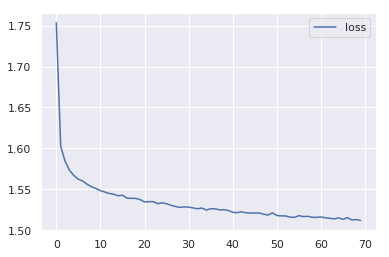

Test accuracy is 0.92380


In [7]:
model = Cmasch().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

batch_size = 256
epochs = 70

history = []

for i in range(epochs):
    loss = train_epoch(model, criterion, optimizer, batch_size)
    history.append(loss)
    if (i+1)%5==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

print(f'Test accuracy is {model_accuracy(model, test, criterion, batch_size):.5f}')

In [0]:
# https://github.com/khanguyen1207/My-Machine-Learning-Corner/blob/master/Zalando%20MNIST/fashion.ipynb
class Khanguyen1207(nn.Module):
    def __init__(self):
        super(Khanguyen1207, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2, 0)
        self.drop1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, 0)
        self.drop2 = nn.Dropout(0.25)
        self.input_size = 64 * 7 * 7
        self.fc1 = nn.Linear(self.input_size, 512)
        self.norm1 = nn.BatchNorm1d(512)
        self.drop3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.drop1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.drop2(x)
        x = x.view(-1, self.input_size)
        x = F.relu(self.fc1(x))
        x = self.norm1(x)
        x = self.drop3(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

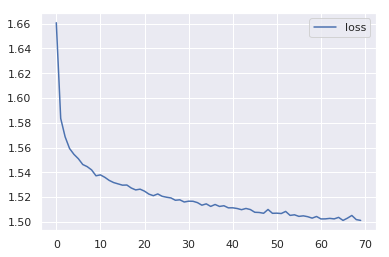

Test accuracy is 0.93090


In [9]:
model = Khanguyen1207().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

batch_size = 256
epochs = 70

history = []

for i in range(epochs):
    loss = train_epoch(model, criterion, optimizer, batch_size)
    history.append(loss)
    if (i+1)%5==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

print(f'Test accuracy is {model_accuracy(model, test, criterion, batch_size):.5f}')

#### Часть 1. Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [0]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [11]:
# Объедините все строки в одну и приведите к нижнему регистру.
# Результат запишите в переменную text.

# Your great code here
text = ''.join(text)
text = text.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('Отлично!')

Отлично!


Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [0]:
tokens = sorted(set(text))

Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [0]:
# словарь вида <индекс>:<символ>
# Your great code here
# tokens - это лист токенов, такми образом он и есть "словарь" <индекс>:<символ>
idx_to_token = tokens

# словарь вида <символ>:<индекс>
# Your great code here
token_to_idx = {t:i for i,t in enumerate(tokens)}

*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*



## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

In [0]:
# Your modified code from class here
class CharRNNModule(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, rnn_size=64):
        super(CharRNNModule, self).__init__()
        self.rnn_size = rnn_size
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_size, batch_first=True)
        self.fc = nn.Linear(rnn_size, num_tokens)
        
    def forward(self, x, state):
        emb = self.emb(x)
        out, state = self.rnn(emb, state)
        logits = F.log_softmax(self.fc(out), dim=-1)
        return logits, state
    
    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn_size, requires_grad=True)

In [0]:
def to_matrix(text, batch_size=32, seq_len=None, dtype=torch.long):
    if not seq_len:
        seq_len = len(text) // batch_size
        
    matrix = []
    for i in range(0, seq_len * batch_size, seq_len):
        matrix.append([token_to_idx[c] for c in text[i:i+seq_len]])

    return torch.tensor(matrix, dtype=dtype)

In [0]:
model = CharRNNModule().to(device)
opt = optim.Adam(model.parameters())
history = []

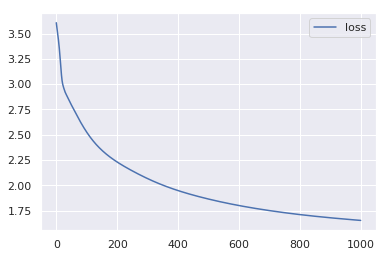

In [17]:
batch_size = 32

batch_ix = to_matrix(text, batch_size).to(device)

for i in range(1000):
    hid_state = model.initial_state(batch_size).to(device)
    logp_seq, _ = model(batch_ix, hid_state)
    
    # compute loss
    #loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, len(tokens)),
    #                  batch_ix[:, :-1].contiguous().view(-1))
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    history.append(loss.item())
    
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

Постройте график функции потерь в зависимости от номера эпохи.

In [0]:
# Your plot code here
# Plotted in training cell

In [18]:
# Пример сгенерированного текста. Функция `generate_text` отсутствует в коде выше.
def generate_text(model, length, seed_phrase=' ', temperature=1.0):
    model.eval()
    model.cpu()
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    
    hid_state = model.initial_state(batch_size=1)
    for i in range(len(seed_phrase) - 1):
        _, hid_state = model(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(length - len(seed_phrase)):
        logp_next, hid_state = model(x_sequence[:, :, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0].ravel()
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens),p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

print(generate_text(model, length=500, temperature=0.2))

 might, the stands the to the strear the streare i see the strant the sweet the see store the strecened the streare the will the streare and my some that the store the streare the sweet the strear the streare the strear the strant the strear in the so then the self the still the streare the strending the love the strear the strear the on the with the strease my love the streare and the beauty the will the streare the strear the with the strick and deare the stall the from the beauty the sur the 


### Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

Снова постройте график функции потерь от числа эпох. Стал ли финальный loss лучше?

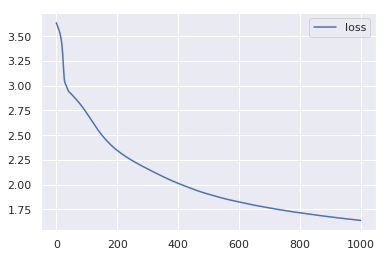

In [19]:
# Your beautiful code here
class CharLSTMModule(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, lstm_size=64):
        super(CharLSTMModule, self).__init__()
        self.lstm_size = lstm_size
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, lstm_size, batch_first=True)
        self.fc = nn.Linear(lstm_size, num_tokens)
        
    def forward(self, x, state):
        emb = self.emb(x)
        out, state = self.lstm(emb, state)
        logits = F.log_softmax(self.fc(out), dim=-1)
        return logits, state
    
    def initial_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size, requires_grad=True),
                torch.zeros(1, batch_size, self.lstm_size, requires_grad=True))


model = CharLSTMModule().to(device)
opt = optim.Adam(model.parameters())
history = []

batch_size = 32
batch_ix = to_matrix(text, batch_size).to(device)

for i in range(1000):
    hid_state = model.initial_state(batch_size)
    hid_state = tuple([each.to(device) for each in hid_state])
    logp_seq, _ = model(batch_ix, hid_state)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    history.append(loss.item())
    
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

Сгенерируйте текст с помощью обученной сети для различных значений параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]` ("температуры" при генерации). Оцените результаты визуально, попробуйте их проинтерпретировать.

In [20]:
# Text generation with different tempearature values here
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(generate_text(model, length=500, temperature=t))
    print()

 the where the love,
  and the see the self the see the self thee,
    the worth the the worth the love in the sees,
  and the self the the see shall the the sees,
  the self the self the see the seed the self thee,
    the love the self the self the see store thee,
  the self the self the see the self the love,
  the see stare the see stare the see strees,
  the worth the see so my self the worth thee,
  the self the see the the self the love thee,
  when the love the self the the see streest t

 the self thee,
  the self the worth the the the the sees,
  the the worth the see shall the see self with thee,
  the self the so me the self stall the see,
  the self the sumpint the self the some thee,
  thou my sumper for the thou hast the prease,
  and the self the summer the seed the seed
  that the see his the see store and the sees,
  and the the so me where the love the love thee,
    the beauty the see stress and the love thee,
    the that the self the see the self in thee mese,
  t

Здесь можно оставить свои рассуждения касательно интерпретации результатов.

We can also play with the temperature of the Softmax during sampling. Decreasing the temperature from 1 to some lower number (e.g. 0.5) makes the RNN more confident, but also more conservative in its samples.

#### Сохранение и загрузка модели

Сохраните обученную модель на диск, затем загрузите ее и сгенерируйте текст. Примеры доступны по [ссылке](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [21]:
# Saving and loading code here
torch.save(model.state_dict(), 'CharLSTMModule.pt')
model = CharLSTMModule()
model.load_state_dict(torch.load('CharLSTMModule.pt'))
model.eval()

print(generate_text(model, length=500, temperature=0.2))

 thee where the self thee,
    the prown the warter the love in thy self,
  the self should the thou beauty so me thee,
  when the self the self the wort the see self,
  and the the self the more the see seed in thee,
    the see so the love the seak the love in thee,
  and the the that the worth the sure thee with thee,
    the worth the the see and the dear the warte,
  when the beart the see with the so me thee,
  and the see the the self the see so thee,
  and the sand the love in the love t


Данная часть задания завершена.

#### Полезные ссылки
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Статья Андрея Карпатого про RNN. </a> В качестве примеров рассматриваются задачи генерации Шекспировских текстов, Latex формул, Linux Source Code и детских имен.
2. <a href='https://github.com/karpathy/char-rnn'> Репозиторий с кодом по char-rnn </a> (тоже за авторством Андрея Карпатого)
3. Полезный репозиторий по PyTorch: [ссылка](https://github.com/spro/practical-pytorch`)

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________

Части задания 3 (HAR classification) и 4 (kaggle) доступны на выбор. Вы можете выполнить одну из них, или обе.

### Часть 3. HAR classification with raw data (2+ points)
__Disclaimer__: В данном задании придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [0]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [0]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [0]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [0]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 85%.__
Разбалловка следующая:
* $=$85% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [0]:
# Your experiments here

### Часть 4. Dogs classification.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$96% - 2 points
* $>=$85% - 1.5 points
* $>=$70% - 0.75 points